In [56]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
import glob
import time
from math import sqrt

In [57]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, mean_squared_error #, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier

In [58]:
import myMLfunctions

In [61]:
def calculate_ic(Y_proba, R_test):
    """
    Calculate the information coefficient (IC) between predicted probabilities and actual returns.
    
    Parameters:
    -----------
    Y_proba : array-like, shape (n_samples,)
        Predicted probabilities of the positive class (class 1).
    R_test : array-like, shape (n_samples,)
        Actual returns corresponding to the same observations as Y_proba.
    
    Returns:
    --------
    ic : float
        The information coefficient between Y_proba and R_test.
    """
    # Calculate the Pearson correlation coefficient between Y_proba and R_test
    corr = np.corrcoef(Y_proba, R_test)[0, 1]
    
    # Calculate the number of observations in Y_proba
    n = len(Y_proba)
    
    # Calculate the information coefficient
    ic = corr * np.sqrt(n)
    
    return ic

In [62]:
def ptfo_metrics(backtest):
    
    monthly_returns = backtest.pct_change(1)
    monthly_returns = monthly_returns.dropna()
    cumulative_return =((monthly_returns+1).cumprod()-1)
    annualized_return = ((1+cumulative_return[-1])**(12/len(backtest)))-1
    
    cum_returns = np.array(backtest) / backtest[0]
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (peak - cum_returns) / peak
    mdd = np.max(drawdown)
    
    colmar = annualized_return/mdd
    volatility = monthly_returns.std() * np.sqrt(12) * 100
    sharpe = (annualized_return*100)/volatility
    return print(
        ' cumulative return:', round(cumulative_return[-1]*100,2),
        '\n',
        'annualized return:', round(annualized_return*100,2),
        '\n',
        'volatility:', round(volatility,2),
        '\n',
        'mdd:', round(mdd*100,2),
        '\n', 
        'sharpe:', round(sharpe,2),
        '\n', 
        'colmar:', round(colmar,2)
    )

In [63]:
pd.set_option("display.max_columns", None)
random.seed(1)

In [65]:
df = pd.read_excel('practicum_data2.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'practicum_data2.xlsx'

<a id='data'></a>
## Equity factor dataset
##### Our dataset includes monthly observations since 2009 for 20 factors

In [38]:
df

,DATE,COUNTRY,INDUSTRY,RET1M,SIZE,PE,PFCF,EVEBITDA,PB,DY,R12M1M,IMOM12M1M,UPDOWN6,SUE6,ROE,FCFROIC,VOL6M,BETA12M,NDE,NDEBITDA,SPSTSTAT,FCFROICTSTAT,DISPERSION,ACCTACF
0,20091231,United States,Consumer Services,-6.772226,10.997537,1.243996,3.206262,2.490379,6.002323,0.000000,165.035110,18.385674,90.769230,0.848751,20.725244,48.789809,0.506947,0.865906,-101.283124,-259.914100,8.997730,2.312226,0.103550,-12.653356
1,20091231,United States,Consumer Goods,-0.262219,8.293164,3.558151,6.873586,8.351408,31.205132,1.203147,46.735237,-1.492745,90.000000,8.204284,11.402454,9.251339,0.581965,1.444075,61.871542,193.771970,3.869876,-0.559776,0.030878,-2.542782
2,20091231,United States,Utilities,-6.092578,9.558148,7.761516,-0.218933,14.730466,59.973426,4.736276,-6.792927,-20.064210,12.500000,-0.094083,12.941592,-0.153923,0.204283,0.641477,168.523316,341.225560,2.391393,-4.812240,0.037006,-2.616270
3,20091231,United States,Health Care,-3.400373,7.884262,3.711333,8.160774,11.618211,45.521129,0.000000,28.389336,-10.518700,100.000000,1.984130,8.152989,11.019458,0.235552,0.810146,8.432803,31.601107,5.955799,0.917888,0.021774,-5.000383
4,20091231,United States,Telecommunications,-9.764570,11.450472,5.895960,14.420034,17.952988,45.969115,6.040801,-1.725680,-19.421078,-57.894737,-1.116297,12.825916,9.543098,0.185659,0.609685,141.543556,173.301770,17.325500,-0.700588,0.006650,-9.978651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,20220729,United States,Industrials,-3.591311,9.648496,4.702402,4.414632,7.142257,12.468980,1.527363,-20.462560,-20.156944,53.571430,0.593995,37.712807,14.537960,0.352888,1.021419,159.870634,232.713167,2.905049,0.021735,0.019939,-3.847408
13232,20220729,United States,Consumer Services,-0.850564,10.641645,5.748669,6.347390,7.210896,-8.095375,0.000000,31.618595,29.448414,77.272730,2.454391,NaN,49.830602,0.342036,0.722626,NaN,237.912393,6.060645,-0.012402,0.009468,-9.287755
13233,20220729,United States,Industrials,1.364470,11.516220,2.852187,2.670487,4.090817,4.179108,1.750166,3.548348,11.555648,96.428570,3.743097,68.248706,35.608155,0.287670,0.946713,42.374013,42.535312,11.696677,-0.021093,0.021363,-1.014506
13234,20220729,United States,Telecommunications,-9.482569,12.175535,11.031791,7.759886,13.303431,43.179667,5.596449,-5.573422,4.417944,-100.000000,-3.880715,25.548578,6.068094,0.228966,0.252528,211.396576,357.348994,0.762200,0.612774,0.006778,-4.615708


<a id='zscore'></a>
## Data pre-processing

#### Features/Factors

In [39]:
zscore = lambda x: (x - x.mean()) / x.std()

list_of_factors = [
    "SIZE",
    "PE",
    "PFCF",
    "EVEBITDA",
    "PB",
    "DY",
    "R12M1M",
    "IMOM12M1M",
    "UPDOWN6",
    "SUE6",
    "ROE",
    "FCFROIC",
    "VOL6M",
    "BETA12M",
    "NDE",
    "NDEBITDA",
    "SPSTSTAT",
    "FCFROICTSTAT",
    "DISPERSION",
    "ACCTACF",
]

P = df["DATE"]
G = df["DATE"].astype(str).str.cat(df["INDUSTRY"])

X = df[list_of_factors].copy()

# trim factors between 2% and 98%
X = X.groupby(P).transform(
    lambda x: x.clip(np.nan_to_num(x.quantile(0.02)), np.nan_to_num(x.quantile(0.98)))
)

# winsorize the data using z-scores and capping between -3 and 3 stds
number_of_winsorizations = 1
for i in range(number_of_winsorizations):
    X = X.groupby(G).transform(zscore)
    X = X.clip(-3, 3)

# for factors where lower value is better multiply z-score by -1
low_value_ranks_better_factors = [
    "SIZE",
    "VOL6M",
    "BETA12M",
    "NDE",
    "NDEBITDA",
    "DISPERSION",
    "ACCTACF",
]

X[low_value_ranks_better_factors] = -1 * X[low_value_ranks_better_factors]

# Only doing this to simplify some of the below examples
X = X.round(2)

X

,SIZE,PE,PFCF,EVEBITDA,PB,DY,R12M1M,IMOM12M1M,UPDOWN6,SUE6,ROE,FCFROIC,VOL6M,BETA12M,NDE,NDEBITDA,SPSTSTAT,FCFROICTSTAT,DISPERSION,ACCTACF
0,-1.79,0.11,-0.55,-1.51,-1.32,-0.57,1.82,0.33,0.90,0.10,0.68,2.13,-0.92,0.36,1.53,1.13,0.21,0.84,0.33,0.01
1,0.41,0.32,-0.03,-0.77,-0.20,-0.44,0.19,0.07,0.68,1.69,-0.09,-0.51,-1.65,-0.87,0.33,0.02,-0.47,-0.03,0.31,-0.70
2,-1.00,0.50,-0.19,0.46,-0.73,0.47,-0.61,-0.55,0.15,-0.60,0.58,-0.27,0.17,0.34,-0.62,0.18,0.09,-1.38,0.14,0.18
3,1.06,0.33,0.67,0.58,0.14,-0.82,0.35,-0.56,1.57,0.42,0.07,-0.13,0.30,-0.29,0.08,0.18,-0.05,0.50,0.22,-0.33
4,-1.53,0.42,0.44,0.19,-0.42,0.93,-0.75,-0.67,-1.03,-0.71,0.93,0.35,1.04,1.09,-1.27,-0.01,2.20,-0.86,1.20,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,0.21,-0.16,0.33,-0.08,-0.51,-0.21,-0.25,-1.08,0.92,0.46,-0.26,-0.16,-0.06,-0.20,-1.25,-0.55,-0.39,0.63,0.13,0.49
13232,-0.42,-0.50,-0.27,-0.53,-0.94,-0.97,1.45,1.20,1.11,0.77,NaN,1.73,0.72,0.88,NaN,-0.00,0.71,0.14,0.58,1.51
13233,-1.22,-0.89,-0.31,-1.18,-1.09,-0.05,1.73,1.12,1.53,1.44,0.01,0.91,0.65,0.06,0.38,0.72,1.91,0.61,-0.04,-0.41
13234,-0.81,0.26,-0.41,0.12,-0.47,0.53,-0.23,0.29,-1.69,-1.60,1.37,-0.26,1.20,1.22,-0.83,0.64,-0.07,-0.63,0.69,-0.82


#### Classification

In [40]:
# for classification we can choose the percentage of stocks we consider as out/underperformers

percent_of_tail = 0.2

Y = df["RET1M"].groupby(G).transform(lambda x: x.rank(pct=True))

Y = (1 * (Y > (1 - percent_of_tail)) - 1 * (Y <= percent_of_tail)).mask(Y.isnull())

Y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13231    0.0
13232    1.0
13233    1.0
13234   -1.0
13235    0.0
Name: RET1M, Length: 13236, dtype: float64

### Dealing with missing data

In [41]:
print("Number of samples missing per factor:")
pd.concat([X, Y], axis=1).isnull().sum()

Number of samples missing per factor:


SIZE              0
PE                1
PFCF              1
EVEBITDA          3
PB                0
DY              373
R12M1M            0
IMOM12M1M         0
UPDOWN6          14
SUE6             31
ROE             509
FCFROIC           3
VOL6M             0
BETA12M           0
NDE             511
NDEBITDA        103
SPSTSTAT          1
FCFROICTSTAT      5
DISPERSION       35
ACCTACF           1
RET1M            36
dtype: int64

In [42]:
# exclude all samples with missing returns
X    = X[Y.notnull()]
Y    = Y[Y.notnull()]

# exclude all samples missing more than 5 out of 20 factor scores
Y    = Y   [X.isnull().sum(axis=1) < 5]
X    = X   [X.isnull().sum(axis=1) < 5]

# set all other missing z-scores to 0
X = X.fillna(0)

RET = df.loc[X.index, "RET1M"]
P   = df.loc[X.index, "DATE"]

print("Number of samples missing per factor:")
pd.concat([X, Y], axis=1).isnull().sum()

Number of samples missing per factor:


SIZE            0
PE              0
PFCF            0
EVEBITDA        0
PB              0
DY              0
R12M1M          0
IMOM12M1M       0
UPDOWN6         0
SUE6            0
ROE             0
FCFROIC         0
VOL6M           0
BETA12M         0
NDE             0
NDEBITDA        0
SPSTSTAT        0
FCFROICTSTAT    0
DISPERSION      0
ACCTACF         0
RET1M           0
dtype: int64

#### Training and testing sets

In [43]:
dates = df.loc[X.index, "DATE"]
last_month_end = dates.max()

# Test set is data from last month end
X_test    = X   [dates == last_month_end]
Y_test    = Y   [dates == last_month_end]

# Train set is all data excluding most recent month end
# In the train set we exclude the middle class and only consider the out/underperformers
X_train    = X   [(dates < last_month_end) & (Y != 0).values]
Y_train    = Y   [(dates < last_month_end) & (Y != 0).values]


# *************************************

# manual modeling and backtesting

In [44]:
# model specification

model_name = GradientBoostingClassifier

params = {}
params["max_leaf_nodes"] = 5
params["min_samples_leaf"] = 0.1
params["n_estimators"] = 50
params["learning_rate"] = 1
params["max_features"] = 20
params["subsample"] = 1

training_window = 60 

D = P.unique() # for each unique month
out = pd.DataFrame(columns=['date', 'insample rmse', 'outsample rmse', 'accuracy', 'f1-score', 'forward return 1m', 'IC', 'predicted_class', 'Y_proba'])

# Loop for training and backtesting
for current_month_id in range(training_window, len(P.unique())):
    
    # training
    # we train only on the tails -> it becomes a binary classification model
    X_train = X[(P >= D[current_month_id - training_window]) & (P < D[current_month_id]) & (Y != 0)].copy()
    Y_train = Y[(P >= D[current_month_id - training_window]) & (P < D[current_month_id]) & (Y != 0)].copy()
    
    # testing
    X_test = X[P == D[current_month_id]]
    R_test = RET[P == D[current_month_id]]
    
    # modeling
    model = model_name(**params, random_state=42)
    fit = model.fit(X_train, Y_train)
    
    # get the predicted class
    # it will only predict 1 and -1
    predicted_class = fit.predict(X_test)
    
    # get the proba to be in the top quintile
    Y_proba = fit.predict_proba(X_test)[:, 1] # to obtain the prob of class 1
    
    # evaluate the model
    Y_insample = fit.predict(X_train)
    insample_mse = mean_squared_error(Y_train, Y_insample)
    insample_rmse = np.sqrt(insample_mse)
    Y_outsample = fit.predict(X_test)
    outsample_mse = mean_squared_error(R_test, Y_outsample)
    outsample_rmse = np.sqrt(outsample_mse)
    acc = accuracy_score(Y_train, Y_insample)
    f1 = f1_score(Y_train, Y_insample)
    ic = calculate_ic(Y_proba, R_test)  # Assuming calculate_ic is defined
    
    # forward return of the equal weight portfolio made of the stocks in the top quintile
    ret_forward_1m = np.mean(R_test[Y_proba > np.percentile(Y_proba, 80)]) - np.mean(R_test[Y_proba <= np.percentile(Y_proba, 20)])

    out.loc[current_month_id - training_window] = [D[current_month_id], insample_rmse, outsample_rmse, acc, f1, ret_forward_1m, ic, predicted_class, Y_proba]

out.reset_index(drop=True, inplace=True)
out

,date,insample rmse,outsample rmse,accuracy,f1-score,forward return 1m,IC,predicted_class,Y_proba
0,20141231,0.977685,8.402140,0.761033,0.765762,2.895412,1.543830,"[-1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -...","[0.4155076496790982, 0.6125176872266039, 0.118..."
1,20150130,0.985339,9.031767,0.757277,0.761861,2.696681,0.770239,"[-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0,...","[0.4797984877572464, 0.3399831509231064, 0.383..."
2,20150227,0.970939,6.603474,0.764319,0.771194,-3.498494,-1.555373,"[-1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, ...","[0.3586389271806244, 0.5190125979864378, 0.106..."
3,20150331,0.984616,6.795428,0.757633,0.763952,-1.554699,-0.234932,"[-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...","[0.30553145430273093, 0.6690291099172108, 0.26..."
4,20150430,0.977915,7.265399,0.760921,0.766621,0.324799,0.839563,"[-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0,...","[0.46422426980994497, 0.4869279317113787, 0.95..."
...,...,...,...,...,...,...,...,...,...
87,20220331,0.969724,9.076382,0.764909,0.773181,3.646426,1.505187,"[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[0.5457603440028771, 0.804040489201645, 0.5742..."
88,20220429,0.947331,11.336574,0.775641,0.781355,-3.829005,-0.297941,"[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[0.7929577698992649, 0.8253307357423356, 0.600..."
89,20220531,0.956094,12.754285,0.771471,0.778363,-3.410835,-1.548108,"[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1....","[0.709085444689556, 0.6673704609299825, 0.8083..."
90,20220630,0.948032,12.946129,0.775309,0.779661,-2.006846,-1.042150,"[-1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0,...","[0.3311804180239627, 0.5790445986786898, 0.281..."


In [45]:
# evaluate the model
acc= out['accuracy'].mean()
f1 = out['f1-score'].mean()
insample_rmse = out['insample rmse'].mean()
outsample_rmse = out['outsample rmse'].mean()
ic = out['IC'].mean()

print('accuracy:',round(acc*100,2))
print('f1:',round(f1,2))
print('insample rmse:',round(insample_rmse,2))
print('outsample rmse:',round(outsample_rmse,2))
print('ic:',round(ic,2))

accuracy: 76.72
f1: 0.78
insample rmse: 0.96
outsample rmse: 9.36
ic: -0.06


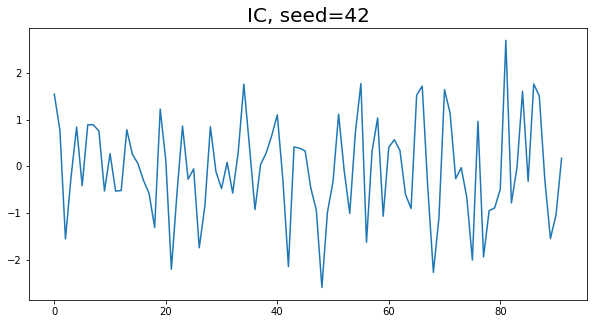

In [46]:
# plot the IC
plt.figure(figsize=(10, 5))
plt.plot(out['IC'])
plt.title("IC, seed=42", fontsize=20)
plt.show()
plt.close()

In [47]:
# building the chained backtested portfolio
out.index = pd.to_datetime(out["date"].astype("int"), format="%Y%m%d")
out = 100 * (1 + out["forward return 1m"].shift(1) / 100).cumprod()
out.iloc[0] = 100
out

date
2014-12-31    100.000000
2015-01-30    102.895412
2015-02-27    105.670173
2015-03-31    101.973308
2015-04-30    100.387930
                 ...    
2022-03-31     95.001303
2022-04-29     98.465455
2022-05-31     94.695208
2022-06-30     91.465311
2022-07-29     89.629743
Name: forward return 1m, Length: 92, dtype: float64

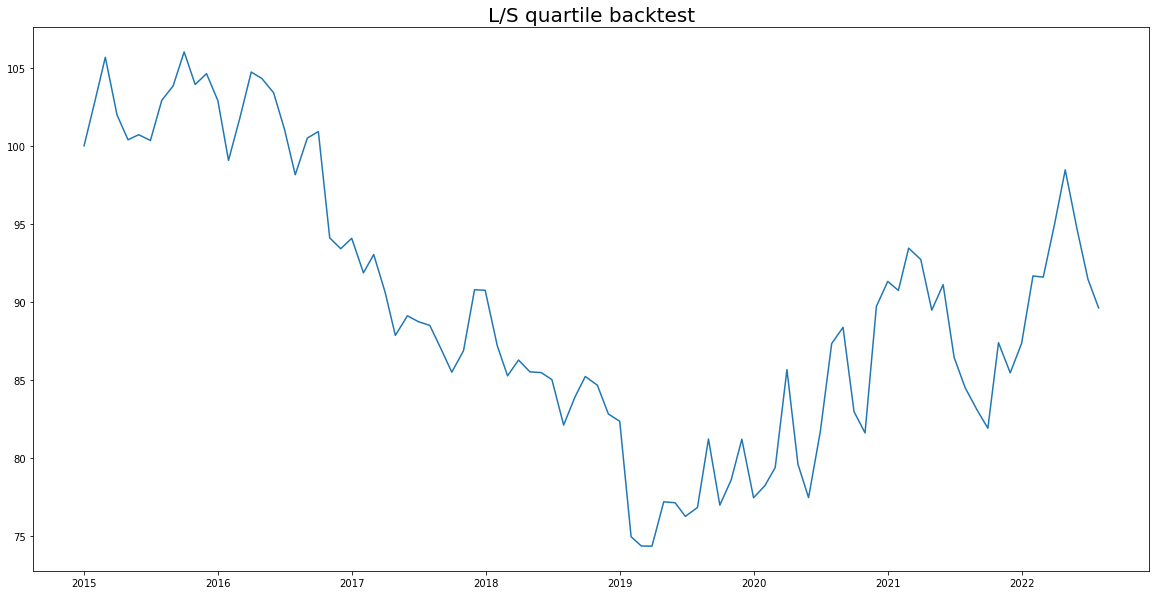

In [48]:
# plotting the backtest
plt.figure(figsize=(20, 10))
plt.plot(out)
plt.title("L/S quartile backtest", fontsize=20)
plt.show()
plt.close()

In [50]:
# financial evaluation
ptfo_metrics(out)

 cumulative return: -10.37 
 annualized return: -1.42 
 volatility: 11.43 
 mdd: 29.83 
 sharpe: -0.12 
 colmar: -0.05


# *************************************

# the same but with a function that will be handy for the grid search

In [51]:
def train_and_backtest_mb(X,Y,P,RET,current_month_id,training_window,params, model_name):
    
    max_leaf_nodes   = params['max_leaf_nodes']
    min_samples_leaf = params['min_samples_leaf']
    n_estimators     = params['n_estimators']
    learning_rate    = params['learning_rate']
    max_features     = params['max_features']
    subsample        = params['subsample']

    D = P.unique()
    
    X_train =  X[(P>=D[current_month_id-training_window]) & (P<D[current_month_id]) & (Y!=0)].copy()
    Y_train =  Y[(P>=D[current_month_id-training_window]) & (P<D[current_month_id]) & (Y!=0)].copy()
    
    X_test =   X[P==D[current_month_id]]
    R_test = RET[P==D[current_month_id]]
    
    model = model_name(max_leaf_nodes = max_leaf_nodes, 
                                     min_samples_leaf = min_samples_leaf, 
                                     n_estimators = n_estimators,
                                     learning_rate = learning_rate, 
                                     max_features = max_features, 
                                     subsample = subsample)
    
    
    # modeling
    model = model_name(**params, random_state=42)
    fit = model.fit(X_train, Y_train)
    
    # get the predicted class
    # it will only predict 1 and -1
    predicted_class = fit.predict(X_test)
    
    # get the proba to be in the top quintile
    Y_proba = fit.predict_proba(X_test)[:, 1] # to obtain the prob of class 1
    
    # evaluate the model
    Y_insample = fit.predict(X_train)
    insample_mse = mean_squared_error(Y_train, Y_insample)
    insample_rmse = np.sqrt(insample_mse)
    Y_outsample = fit.predict(X_test)
    outsample_mse = mean_squared_error(R_test, Y_outsample)
    outsample_rmse = np.sqrt(outsample_mse)
    acc = accuracy_score(Y_train, Y_insample)
    f1 = f1_score(Y_train, Y_insample)
    ic = calculate_ic(Y_proba, R_test)  # Assuming calculate_ic is defined
    
    ret_formward_1m =  np.mean(R_test[Y_proba>np.percentile(Y_proba,80)])-np.mean(R_test[Y_proba<=np.percentile(Y_proba,20)])
    
    out = pd.DataFrame(columns=['date', 'insample rmse', 'outsample rmse', 'accuracy', 'f1-score', 'forward return 1m', 'IC', 'predicted_class', 'Y_proba'])                     
    out.loc[0,'date']               = D[current_month_id]
    out.loc[0,'insample rmse']      = insample_rmse
    out.loc[0,'outsample rmse']     = outsample_rmse
    out.loc[0,'accuracy']           = acc
    out.loc[0,'f1-score']           = f1
    out.loc[0,'forward return 1m']  = ret_formward_1m
    out.loc[0,'IC']                 = ic
    out.loc[0, 'predicted_class']   = predicted_class
    out.loc[0, 'Y_proba']           = Y_proba
    
    return out

In [52]:
training_window = 60  # months

params = {}
params["max_leaf_nodes"] = 5
params["min_samples_leaf"] = 0.1
params["n_estimators"] = 50
params["learning_rate"] = 1
params["max_features"] = 20
params["subsample"] = 1

ml_backtest = pd.concat(
    [
        train_and_backtest_mb(X, Y, P, RET, current_month_id, training_window, params, GradientBoostingClassifier)
        for current_month_id in range(training_window, len(P.unique()))
    ],
    ignore_index=True,
)

ml_backtest

,date,insample rmse,outsample rmse,accuracy,f1-score,forward return 1m,IC,predicted_class,Y_proba
0,20141231,0.977685,8.40214,0.761033,0.765762,2.895412,1.54383,"[-1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -...","[0.4155076496790982, 0.6125176872266039, 0.118..."
1,20150130,0.985339,9.031767,0.757277,0.761861,2.696681,0.770239,"[-1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0,...","[0.4797984877572464, 0.3399831509231064, 0.383..."
2,20150227,0.970939,6.603474,0.764319,0.771194,-3.498494,-1.555373,"[-1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, ...","[0.3586389271806244, 0.5190125979864378, 0.106..."
3,20150331,0.984616,6.795428,0.757633,0.763952,-1.554699,-0.234932,"[-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...","[0.30553145430273093, 0.6690291099172108, 0.26..."
4,20150430,0.977915,7.265399,0.760921,0.766621,0.324799,0.839563,"[-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0,...","[0.46422426980994497, 0.4869279317113787, 0.95..."
...,...,...,...,...,...,...,...,...,...
87,20220331,0.969724,9.076382,0.764909,0.773181,3.646426,1.505187,"[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[0.5457603440028771, 0.804040489201645, 0.5742..."
88,20220429,0.947331,11.336574,0.775641,0.781355,-3.829005,-0.297941,"[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[0.7929577698992649, 0.8253307357423356, 0.600..."
89,20220531,0.956094,12.754285,0.771471,0.778363,-3.410835,-1.548108,"[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1....","[0.709085444689556, 0.6673704609299825, 0.8083..."
90,20220630,0.948032,12.946129,0.775309,0.779661,-2.006846,-1.04215,"[-1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0,...","[0.3311804180239627, 0.5790445986786898, 0.281..."


In [53]:
ml_backtest.index = pd.to_datetime(ml_backtest["date"].astype("int"), format="%Y%m%d")
ml_backtest = 100 * (1 + ml_backtest["forward return 1m"].shift(1) / 100).cumprod()
ml_backtest.iloc[0] = 100
ml_backtest

date
2014-12-31           100
2015-01-30    102.895412
2015-02-27    105.670173
2015-03-31    101.973308
2015-04-30     100.38793
                 ...    
2022-03-31     95.001303
2022-04-29     98.465455
2022-05-31     94.695208
2022-06-30     91.465311
2022-07-29     89.629743
Name: forward return 1m, Length: 92, dtype: object

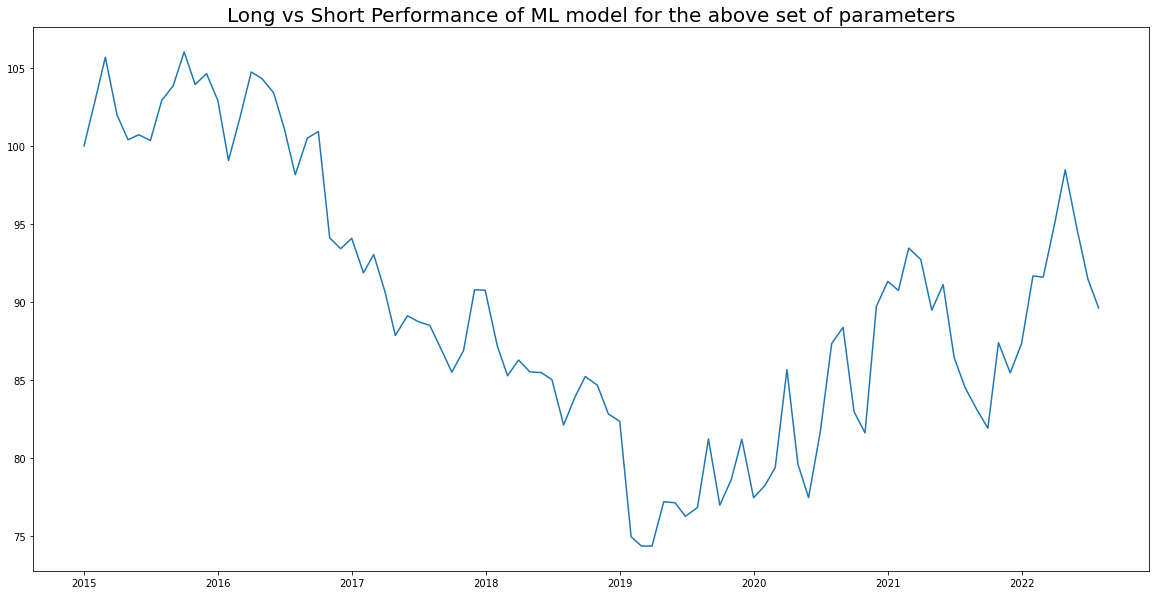

In [54]:
plt.figure(figsize=(20, 10))
plt.plot(ml_backtest)
plt.title("Long vs Short Performance of ML model for the above set of parameters", fontsize=20)
plt.show()
plt.close()

# *****************

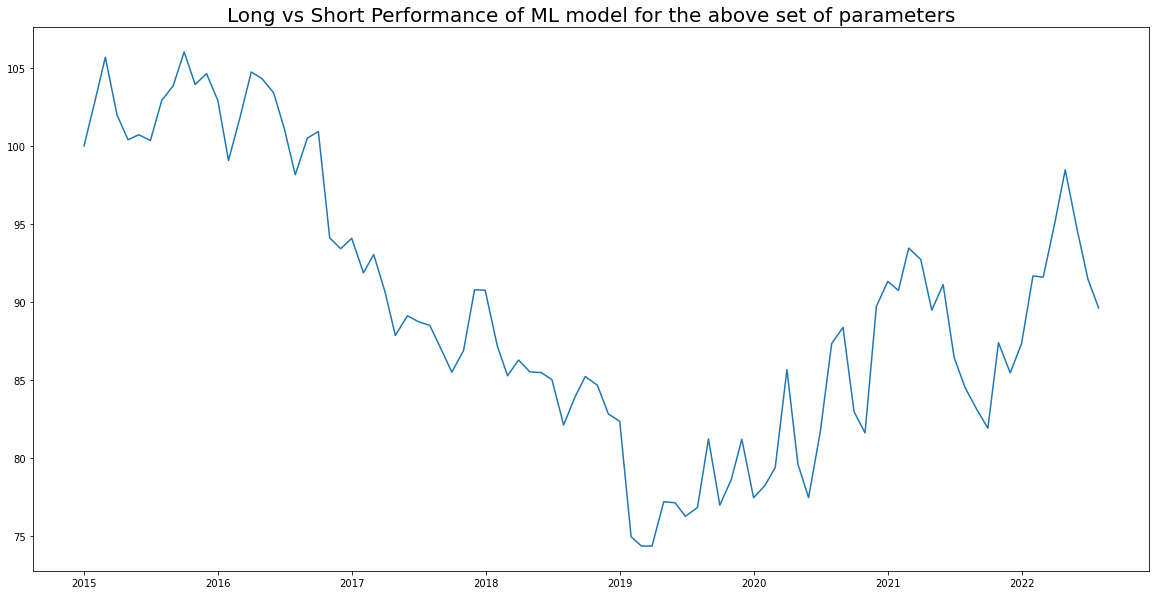

In [55]:
# a further check

training_window = 60  # months

params = {}
params["max_leaf_nodes"] = 5
params["min_samples_leaf"] = 0.1
params["n_estimators"] = 50
params["learning_rate"] = 1
params["max_features"] = 20
params["subsample"] = 1

ml_backtest = pd.concat(
    [
        myMLfunctions.train_and_backtest(X, Y, P, RET, current_month_id, training_window, params)
        for current_month_id in range(training_window, len(P.unique()))
    ],
    ignore_index=True,
)

ml_backtest.index = pd.to_datetime(ml_backtest["date"].astype("int"), format="%Y%m%d")
ml_backtest = 100 * (1 + ml_backtest["forward return 1m"].shift(1) / 100).cumprod()
ml_backtest.iloc[0] = 100

plt.figure(figsize=(20, 10))
plt.plot(ml_backtest)
plt.title("Long vs Short Performance of ML model for the above set of parameters", fontsize=20)
plt.show()
plt.close()

# ****

<a id='cv'></a>
## Cross Validation

<a id='random_search'></a>
### Random Search

<a id='tuning'></a>
### Cross validation grid

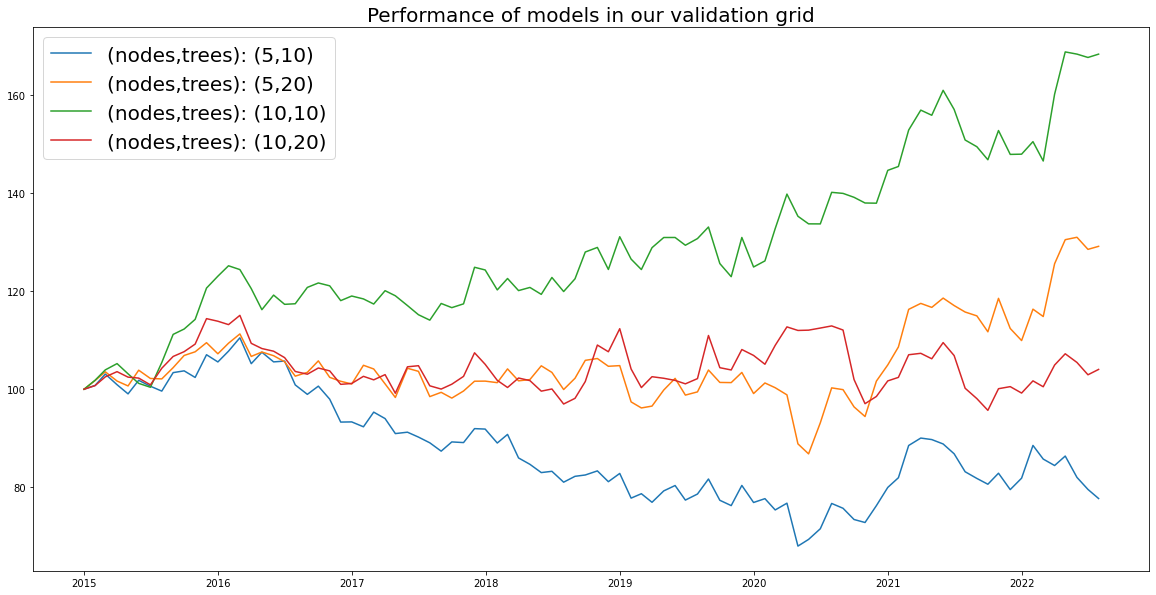

In [16]:
validation_grid_models = []

for max_nodes in [5, 10]:
    for number_of_trees in [10, 20]:
        params = {}
        params["max_leaf_nodes"] = max_nodes
        params["min_samples_leaf"] = 0.1
        params["n_estimators"] = number_of_trees
        params["learning_rate"] = 1
        params["max_features"] = 20
        params["subsample"] = 1

        model = pd.concat(
            [
                myMLfunctions.train_and_backtest(X, Y, P, RET, current_month_id, 60, params)
                for current_month_id in range(60, len(P.unique()))
            ],
            ignore_index=True,
        )

        model.index = pd.to_datetime(model["date"].astype("int"), format="%Y%m%d")
        model = 100 * (1 + model["forward return 1m"].shift(1) / 100).cumprod()
        model.iloc[0] = 100
        model_name = "(nodes,trees): (" + str(max_nodes) + "," + str(number_of_trees) + ")"
        model = model.rename(model_name)
        validation_grid_models.append(model)

validation_grid_models = pd.concat(validation_grid_models, axis=1)

plt.figure(figsize=(20, 10))
plt.plot(validation_grid_models)
plt.legend(loc="upper left", labels=validation_grid_models, prop={"size": 20})
plt.title("Performance of models in our validation grid", fontsize=20)
plt.show()
plt.close()

### Search the grid for the best set of parameters

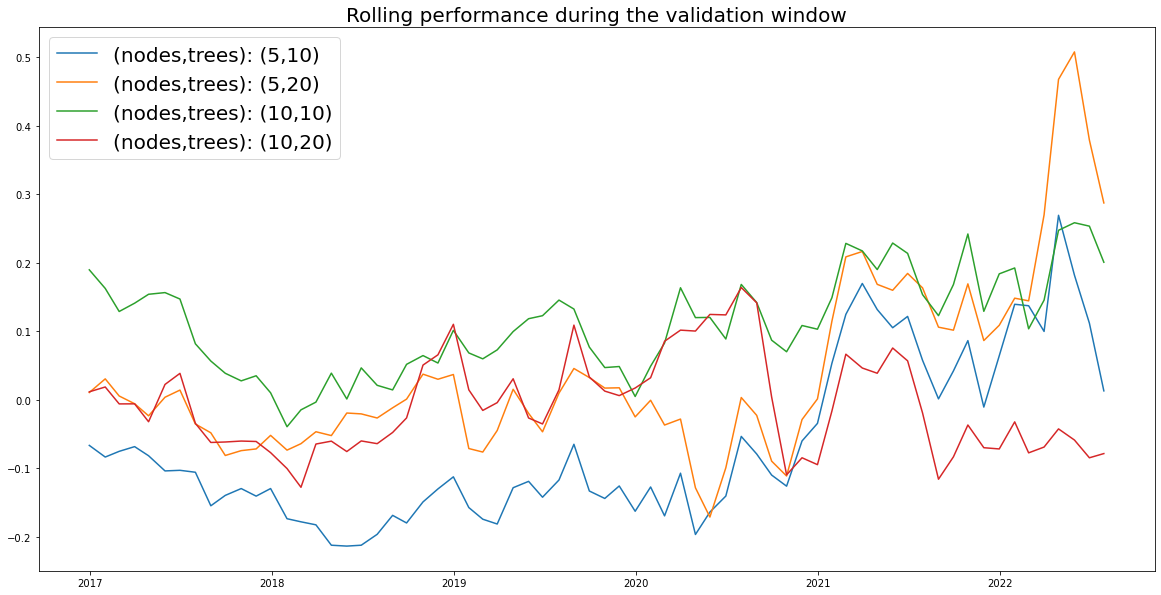

The best parameters for each period:


date
2016-12-30    (nodes,trees): (10,10)
2017-01-31    (nodes,trees): (10,10)
2017-02-28    (nodes,trees): (10,10)
2017-03-31    (nodes,trees): (10,10)
2017-04-28    (nodes,trees): (10,10)
                       ...          
2022-03-31     (nodes,trees): (5,20)
2022-04-29     (nodes,trees): (5,20)
2022-05-31     (nodes,trees): (5,20)
2022-06-30     (nodes,trees): (5,20)
2022-07-29     (nodes,trees): (5,20)
Length: 68, dtype: object

In [17]:
number_of_validation_months = 24

plt.figure(figsize=(20, 10))
plt.plot(validation_grid_models.pct_change(periods=number_of_validation_months))
plt.legend(loc="upper left", labels=validation_grid_models, prop={"size": 20})
plt.title("Rolling performance during the validation window", fontsize=20)
plt.show()
plt.close()

print("The best parameters for each period:")
best_params = validation_grid_models.pct_change(periods=number_of_validation_months).idxmax(axis=1)
best_params.iloc[number_of_validation_months:]

<a id='backtest'></a>
## ML model performance

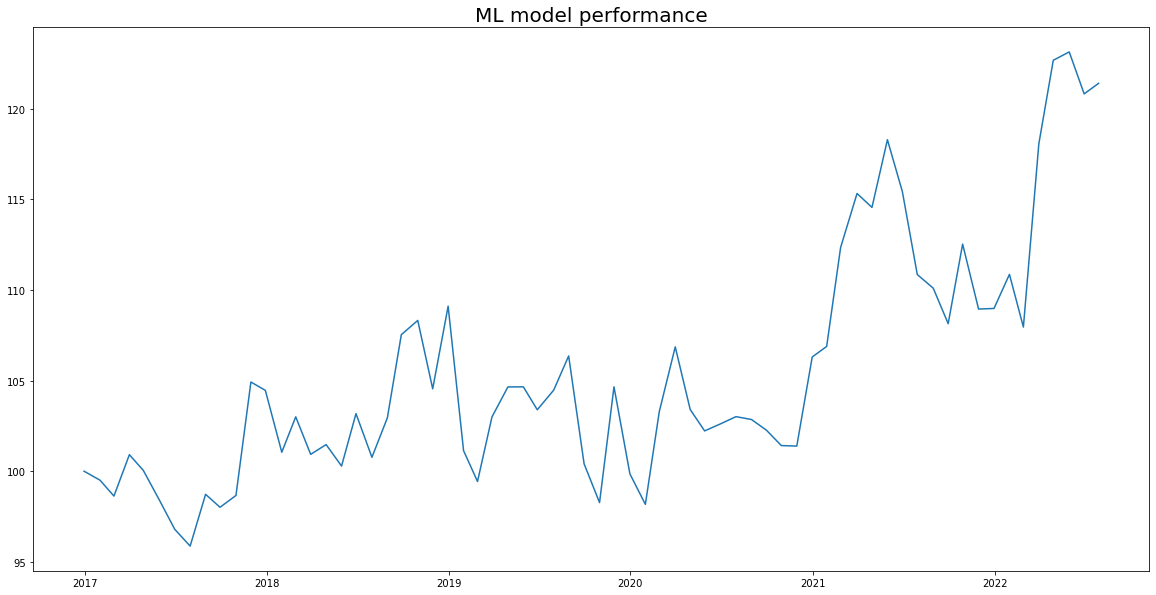

In [18]:
#At the end of each month, we look for the best performing model over the previous 24 months
#Each model corresponds to a different set of parameters
#We use the best model to get predictions for the next month

cross_validated_model_performance = pd.Series(
    [
        validation_grid_models.pct_change(periods=1).shift(-1).loc[date, best_params[date]]
        for date in best_params.iloc[number_of_validation_months:].index
    ],
    index=best_params.iloc[number_of_validation_months:].index,
)

cross_validated_model_performance = 100 * (1 + cross_validated_model_performance.shift(1)).cumprod()
cross_validated_model_performance.iloc[0] = 100

plt.figure(figsize=(20, 10))
plt.plot(cross_validated_model_performance)
plt.title("ML model performance", fontsize=20)
plt.show()
plt.close()

### Traditional vs ML model
#### Performance of traditional equity multi-factor model

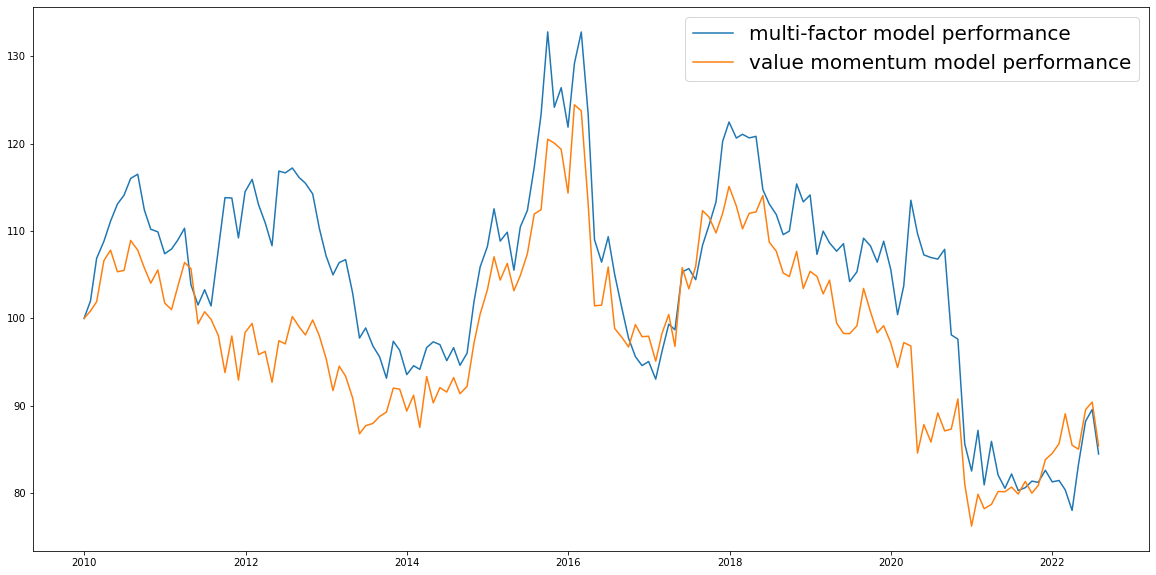

In [19]:
multifactor_perf = myMLfunctions.backtest_top_vs_bottom_quintile(
    scores=X.mean(axis=1), forward_returns=RET, periods=P
)
valuemomentum_perf = myMLfunctions.backtest_top_vs_bottom_quintile(
    scores=X[["PE", "R12M1M"]].mean(axis=1), forward_returns=RET, periods=P
)

plt.figure(figsize=(20, 10))
plt.plot(multifactor_perf, label="multi-factor model performance")
plt.plot(valuemomentum_perf, label="value momentum model performance")
plt.legend(loc="upper right", prop={"size": 20})
plt.show()
plt.close()

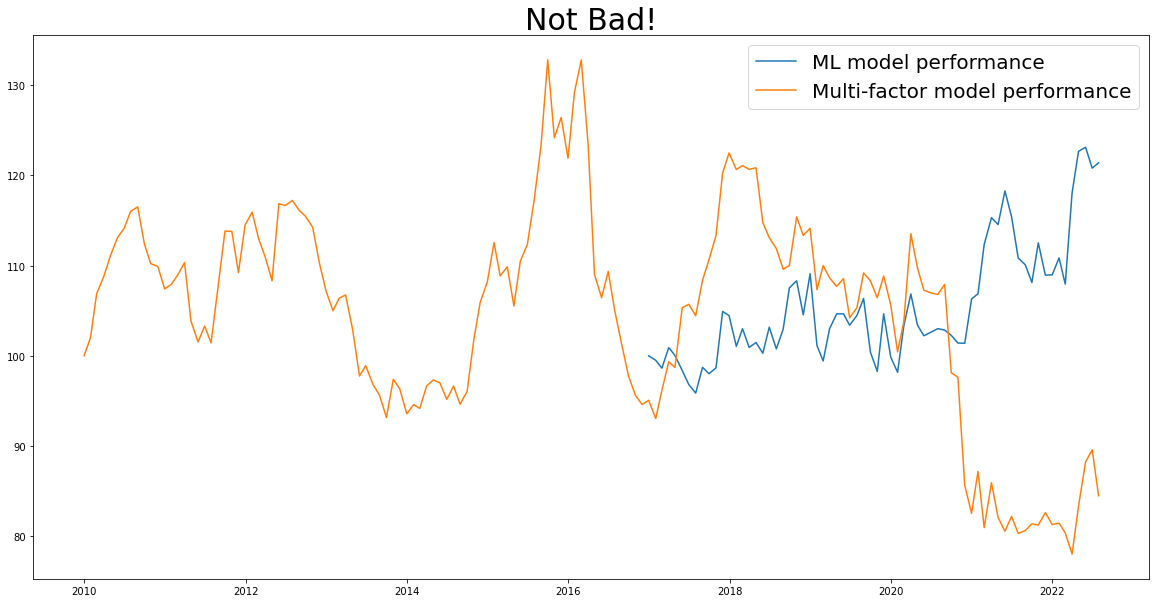

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(cross_validated_model_performance, label="ML model performance")
plt.plot(multifactor_perf, label="Multi-factor model performance")
plt.legend(loc="upper right", prop={"size": 20})
plt.title("Not Bad!", fontsize=30)
plt.show()
plt.close()